In [21]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
IMAGE_FOLDER = '/kaggle/input/pothole-detection-dataset/train/images'  
LABEL_FOLDER = '/kaggle/input/pothole-detection-dataset/train/labels'  

IMAGE_SIZE = (256, 256)  

MAX_POTHOLES = 20  

In [23]:
def load_image(image_path, target_size=IMAGE_SIZE):
    """
    Loads an image from the specified path and resizes it.

    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Desired image size.

    Returns:
        np.ndarray: Preprocessed image.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize to [0, 1]
    return image

In [24]:
def load_labels_for_image(image_filename, label_folder, max_potholes=MAX_POTHOLES):
    """
    Aggregates all label files corresponding to a single image.

    Args:
        image_filename (str): Filename of the image (e.g., '101_jpg.rf.73f6bd6e88c86e891edbbcef3402254a.jpg').
        label_folder (str): Path to the folder containing label files.
        max_potholes (int): Maximum number of potholes to consider per image.

    Returns:
        np.ndarray: Flattened array of bounding boxes with shape (max_potholes * 5,).
                    Each pothole has 5 values: x_center, y_center, width, height, confidence.
    """
    base_name = os.path.splitext(image_filename)[0]
    
    label_files = [f for f in os.listdir(label_folder) if f.startswith(base_name) and f.endswith('.txt')]
    
    boxes = []
    for label_file in label_files:
        label_path = os.path.join(label_folder, label_file)
        with open(label_path, 'r') as file:
            line = file.readline().strip()
            if not line:
                continue  
            values = list(map(float, line.split()))
            if len(values) != 5:
                print(f"Warning: Incorrect label format in {label_file}. Expected 5 values, got {len(values)}.")
                continue  
            class_id, x_center, y_center, width, height = values
            boxes.append([x_center, y_center, width, height, 1.0])  # 1.0 for confidence
    
    num_potholes = len(boxes)
    if num_potholes > max_potholes:
        print(f"Warning: Image {image_filename} has more potholes ({num_potholes}) than MAX_POTHOLES ({max_potholes}). Truncating.")
        boxes = boxes[:max_potholes]
    elif num_potholes < max_potholes:
        for _ in range(max_potholes - num_potholes):
            boxes.append([0, 0, 0, 0, 0.0])  # 0.0 confidence for padding
    
    return np.array(boxes).flatten()

In [25]:
def load_dataset(image_folder, label_folder, max_potholes=MAX_POTHOLES):
    """
    Loads all images and their corresponding labels.

    Args:
        image_folder (str): Path to the images directory.
        label_folder (str): Path to the labels directory.
        max_potholes (int): Maximum number of potholes per image.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Arrays of images and labels.
    """
    images = []
    labels = []
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')]
    
    for img_file in image_files:
        img_path = os.path.join(image_folder, img_file)
        try:
            image = load_image(img_path)
            label = load_labels_for_image(img_file, label_folder, max_potholes)
            images.append(image)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {img_file}: {e}")
    
    images = np.array(images)
    labels = np.array(labels)
    return images, labels


In [26]:
images, labels = load_dataset(IMAGE_FOLDER, LABEL_FOLDER)
print(f'Images shape: {images.shape}')  
print(f'Labels shape: {labels.shape}') 

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f'''
X_train : {X_train.shape[0]}
X_val   : {X_val.shape[0]}
y_train : {y_train.shape}
y_val   : {y_val.shape}
''')


Images shape: (2067, 256, 256, 3)
Labels shape: (2067, 100)

X_train : 1653
X_val   : 414
y_train : (1653, 100)
y_val   : (414, 100)



In [27]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

datagen.fit(X_train)


In [28]:
def build_model(input_shape=(256, 256, 3), max_potholes=MAX_POTHOLES):
    """
    Builds a CNN-based object detection model.

    Args:
        input_shape (tuple): Shape of the input images.
        max_potholes (int): Maximum number of potholes per image.

    Returns:
        tensorflow.keras.Model: Compiled CNN model.
    """
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    
    model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(max_potholes * 5, activation='sigmoid'))
    
    return model

model = build_model()
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        51,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,998,628 (129.69 MB)

 Trainable params: 33,996,644 (129.69 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [29]:
def custom_loss(y_true, y_pred):
    """
    Custom loss function combining localization and confidence losses.

    Args:
        y_true (tensor): Ground truth labels.
        y_pred (tensor): Predicted labels.

    Returns:
        tensor: Combined loss.
    """
    y_true = tf.reshape(y_true, (-1, MAX_POTHOLES, 5))
    y_pred = tf.reshape(y_pred, (-1, MAX_POTHOLES, 5))
    
    true_boxes = y_true[:, :, :4]
    true_conf = y_true[:, :, 4]
    
    pred_boxes = y_pred[:, :, :4]
    pred_conf = y_pred[:, :, 4]
    
    loc_loss = tf.reduce_sum(tf.square(true_boxes - pred_boxes) * tf.expand_dims(true_conf, axis=-1))
    
    conf_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(true_conf, pred_conf))
    
    total_loss = loc_loss + conf_loss
    return total_loss


In [30]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss=custom_loss)


In [31]:
batch_size = 32
epochs = 150

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val)
)


Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 681ms/step - loss: 45.2971 - val_loss: 31.8203
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 41.5078 - val_loss: 32.1649
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 397ms/step - loss: 38.6877 - val_loss: 41.9694
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 40.5529 - val_loss: 42.1355
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 393ms/step - loss: 36.3778 - val_loss: 48.6282
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 35.8566 - val_loss: 48.7429
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 401ms/step - loss: 35.2773 - val_loss: 44.3868
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 33.0658 - val_loss: 44.6611
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 415ms/step - loss: 34.4079 - val_loss: 39.8349
Epoch 10/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 34.7971 - val_loss: 39.7803
Epoch 11/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 394ms/step - loss: 33.5298 - val_loss: 32.1043
Epoch 12/100
51/51 ━━━━

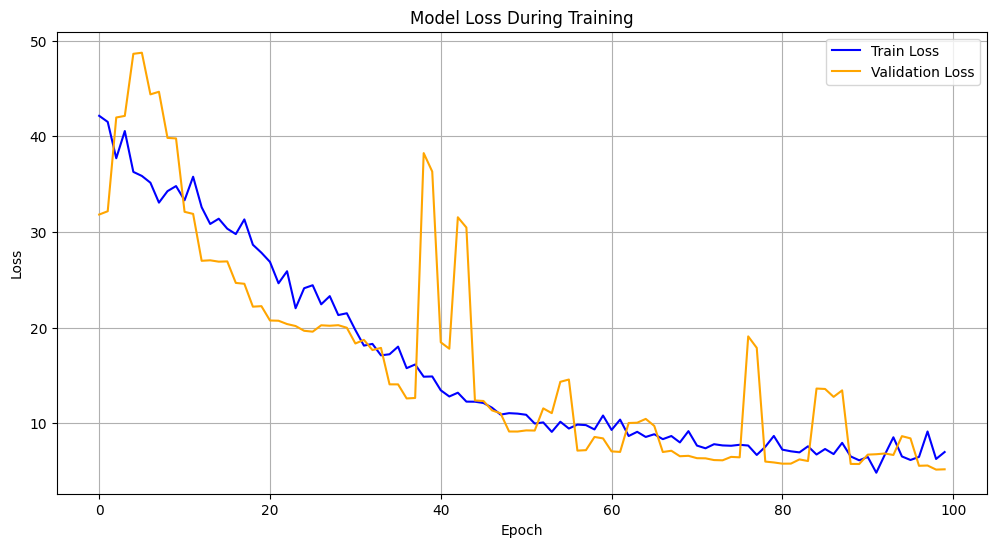

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
def non_max_suppression(boxes, confidences, iou_threshold=0.5):
    """
    Applies Non-Maximum Suppression to eliminate redundant overlapping boxes.

    Args:
        boxes (np.ndarray): Array of bounding boxes [x1, y1, x2, y2].
        confidences (np.ndarray): Array of confidence scores.
        iou_threshold (float): IoU threshold for suppression.

    Returns:
        List[int]: Indices of boxes to keep.
    """
    if len(boxes) == 0:
        return []
    boxes_tensor = tf.constant(boxes, dtype=tf.float32)
    confidences_tensor = tf.constant(confidences, dtype=tf.float32)
    selected_indices = tf.image.non_max_suppression(
        boxes_tensor,
        confidences_tensor,
        max_output_size=MAX_POTHOLES,
        iou_threshold=iou_threshold
    )
    return selected_indices.numpy()


In [34]:
def process_predictions(predictions, threshold=0.5):
    """
    Processes raw model predictions to extract bounding boxes.

    Args:
        predictions (np.ndarray): Raw predictions from the model.
        threshold (float): Confidence threshold to filter boxes.

    Returns:
        List[List[List[int]]]: List of bounding boxes for each image.
    """
    processed_boxes = []
    for pred in predictions:
        boxes = []
        confidences = []
        for i in range(MAX_POTHOLES):
            start = i * 5
            x_center, y_center, width, height, conf = pred[start:start+5]
            if conf > threshold:
                x_center_abs = x_center * IMAGE_SIZE[1]
                y_center_abs = y_center * IMAGE_SIZE[0]
                width_abs = width * IMAGE_SIZE[1]
                height_abs = height * IMAGE_SIZE[0]
                
                x1 = int(x_center_abs - width_abs / 2)
                y1 = int(y_center_abs - height_abs / 2)
                x2 = int(x_center_abs + width_abs / 2)
                y2 = int(y_center_abs + height_abs / 2)
                
                boxes.append([x1, y1, x2, y2])
                confidences.append(conf)
        
        boxes = np.array(boxes)
        confidences = np.array(confidences)
        
        if len(boxes) == 0:
            processed_boxes.append([])
            continue
        
        selected_indices = non_max_suppression(boxes, confidences, iou_threshold=0.3)
        selected_boxes = boxes[selected_indices]
        
        processed_boxes.append(selected_boxes.tolist())
    
    return processed_boxes


In [35]:
def visualize_predictions(image, boxes, title="Predictions"):
    """
    Displays an image with bounding boxes.

    Args:
        image (np.ndarray): Image array.
        boxes (List[List[int]]): List of bounding boxes [x1, y1, x2, y2].
        title (str): Title of the plot.
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    ax = plt.gca()
    
    for box in boxes:
        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
    
    plt.title(title)
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


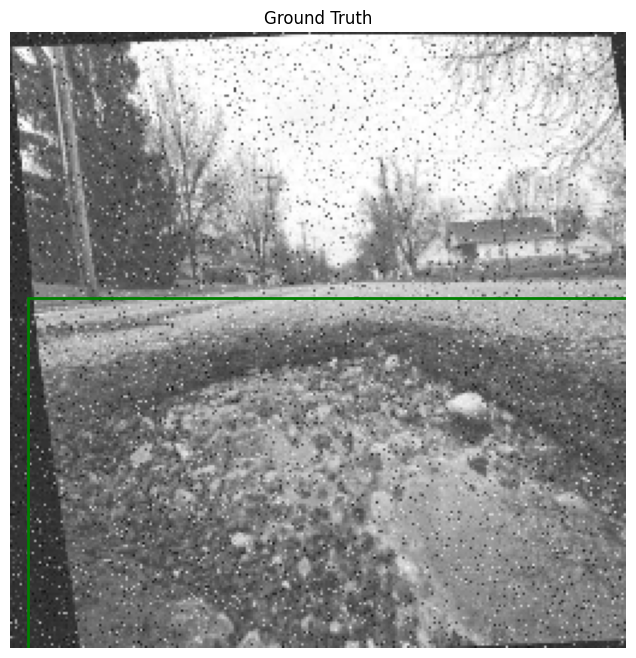

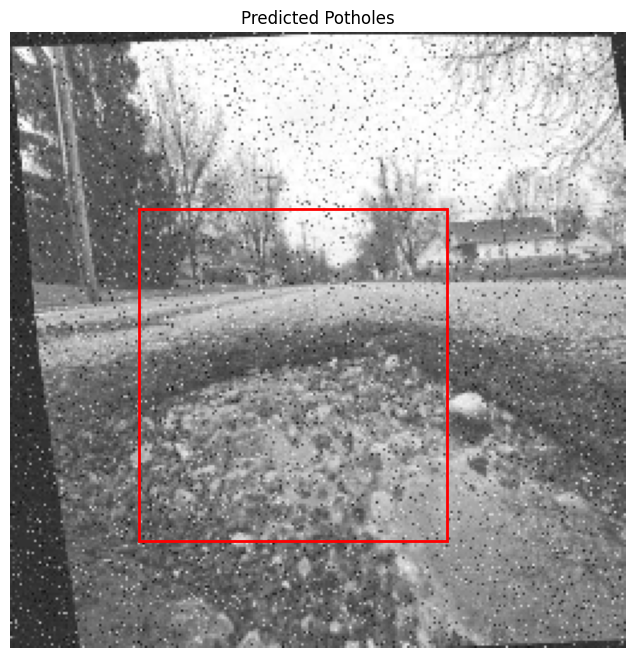

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


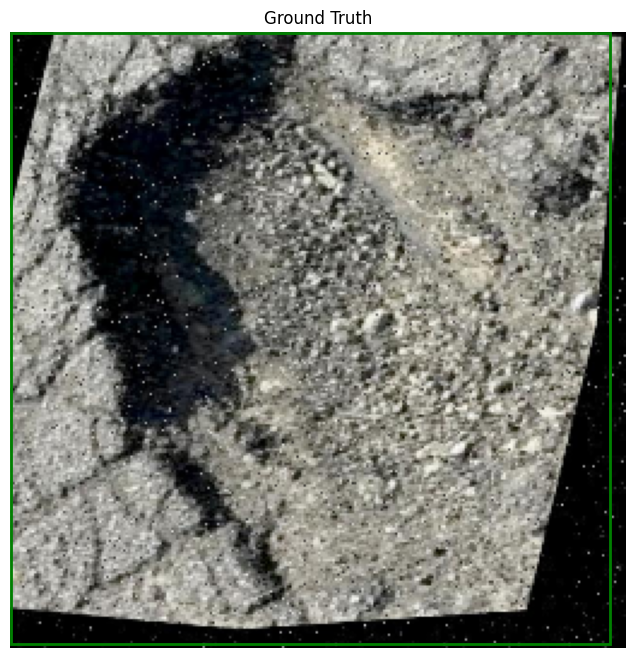

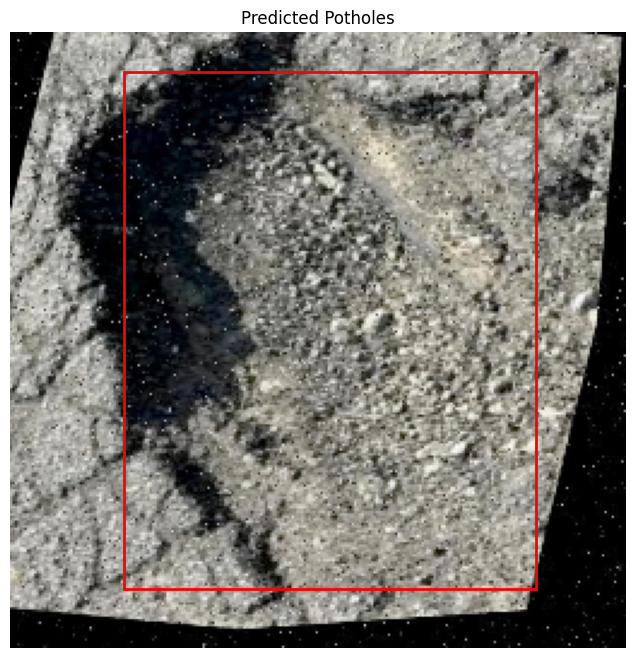

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


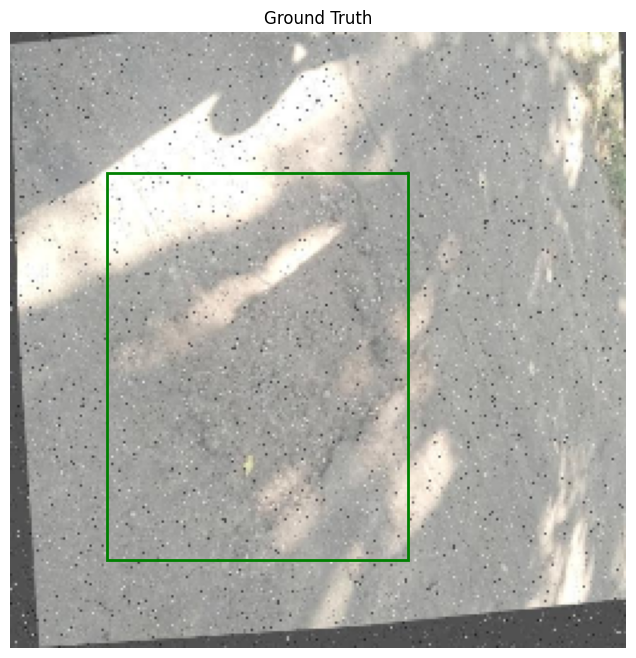

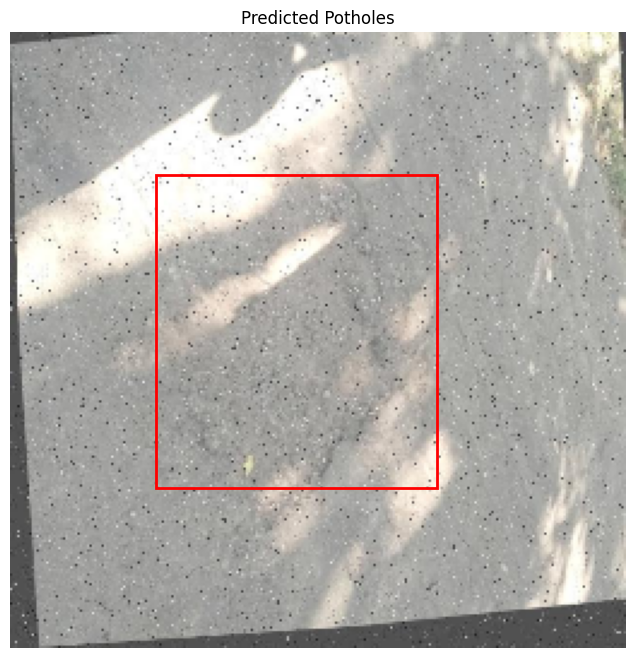

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


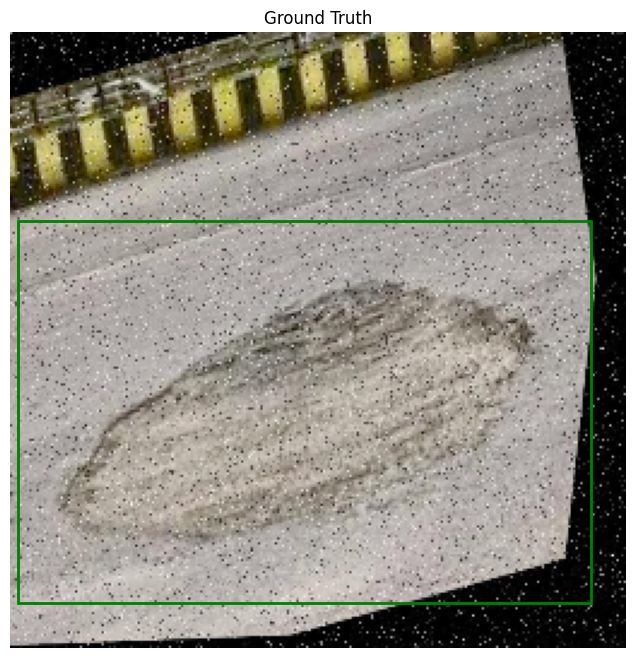

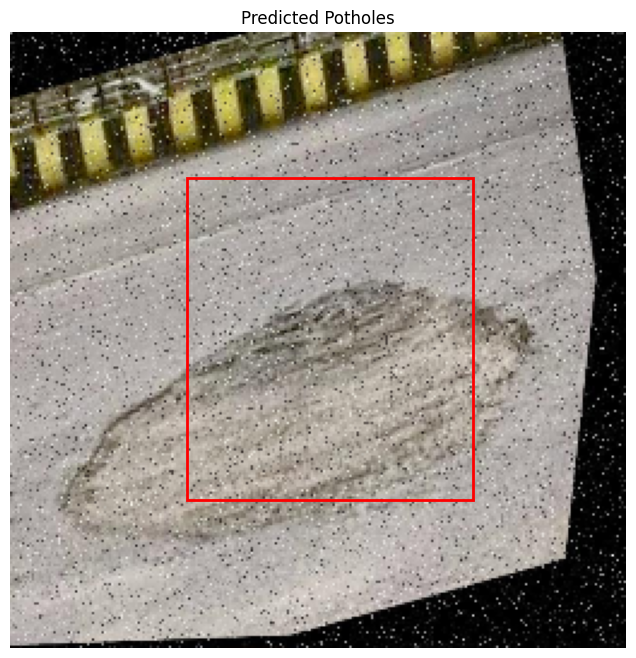

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


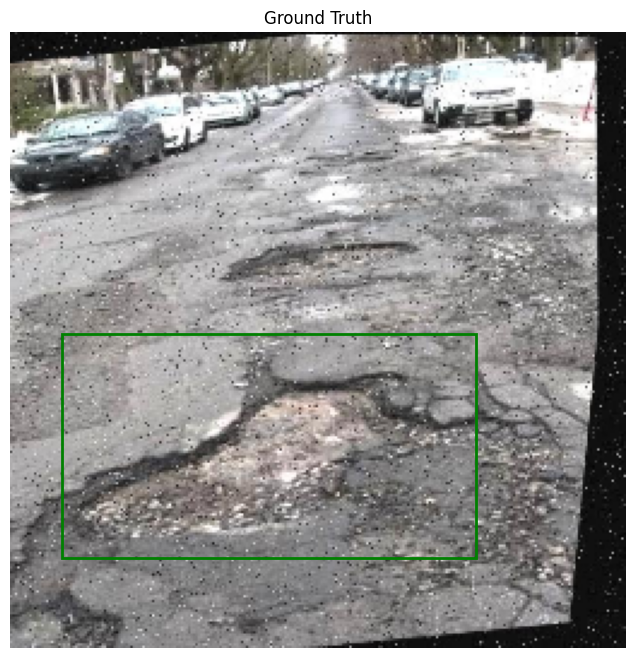

In [ ]:
num_samples = 5
indices = np.random.choice(len(X_val), num_samples, replace=False)

for idx in indices:
    image = X_val[idx]
    true_label = y_val[idx]
    
    true_boxes = true_label.reshape(-1, 5)[:, :4]
    true_conf = true_label.reshape(-1, 5)[:, 4]
    
    gt_boxes = []
    for box, conf in zip(true_boxes, true_conf):
        if conf == 0:
            continue 
        x_center, y_center, width, height = box
        x_center_abs = x_center * IMAGE_SIZE[1]
        y_center_abs = y_center * IMAGE_SIZE[0]
        width_abs = width * IMAGE_SIZE[1]
        height_abs = height * IMAGE_SIZE[0]
        
        x1 = int(x_center_abs - width_abs / 2)
        y1 = int(y_center_abs - height_abs / 2)
        x2 = int(x_center_abs + width_abs / 2)
        y2 = int(y_center_abs + height_abs / 2)
        
        gt_boxes.append([x1, y1, x2, y2])
    
    prediction = model.predict(np.expand_dims(image, axis=0))
    prediction = prediction[0]
    
    predicted_boxes = process_predictions([prediction])[0]
    
    image_disp = (image * 255).astype(np.uint8)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(image_disp)
    ax = plt.gca()
    for box in gt_boxes:
        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             linewidth=2, edgecolor='green', facecolor='none')
        ax.add_patch(rect)
    plt.title("Ground Truth")
    plt.axis('off')
    plt.show()
    
    visualize_predictions(image_disp, predicted_boxes, title="Predicted Potholes")


In [ ]:
def preprocess_image_inference(image_path, target_size=IMAGE_SIZE):
    """
    Loads and preprocesses an image for inference.

    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Desired image size.

    Returns:
        np.ndarray: Preprocessed image.
    """
    image = load_image(image_path, target_size)
    return image


In [ ]:
def predict_potholes(model, image_path, threshold=0.5):
    """
    Predicts potholes in an image and visualizes the results.

    Args:
        model (tensorflow.keras.Model): Trained model.
        image_path (str): Path to the image file.
        threshold (float): Confidence threshold for predictions.
    """
    image = preprocess_image_inference(image_path)
    image_input = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image_input)
    
    predicted_boxes = process_predictions(prediction, threshold=threshold)[0]
    
    image_disp = (image * 255).astype(np.uint8)
    
    visualize_predictions(image_disp, predicted_boxes, title="Predicted Potholes")


In [ ]:
test_image_path = '/kaggle/input/pothole-detection-dataset/valid/images/12_jpg.rf.c1509424ec0b2f24bd396d890752db7a.jpg'  # Replace with your image path

predict_potholes(model, test_image_path, threshold=0.5)
